# CS5489 - Machine Learning
# Lecture 5b - Supervised Learning - Regression
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Linear Regression
2. Selecting Features
3. **Removing Outliers**
4. Non-linear regression

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")  # change to svg later
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Outliers
- Too many outliers in the data can affect the squared-error term.
  - regression function will try to reduce the large prediction error for outliers, at the expense of worse prediction for other points
  

In [2]:
linbias = 30
[linX, linY, lincoefs] = datasets.make_regression(n_samples=100, n_features=1, 
                                                  n_informative=1, bias=linbias, noise=5.0, 
                                                  coef=True, random_state=4487)
# outliers
outbias = 10
[outX, outY, outcoefs] = datasets.make_regression(n_samples=10, n_features=1, 
                                                  n_informative=1, bias=outbias, noise=5.0, 
                                                  coef=True, random_state=447)

# combine
outlinX = r_[linX, 2+outX/2]
outlinY = r_[linY, outY]

# fit using ordinary least squares
ols = linear_model.LinearRegression()
ols.fit(outlinX, outlinY)

# fit using ridge regression
alpha = 100
rr = linear_model.Ridge(alpha=alpha)
rr.fit(outlinX, outlinY)

oaxbox = [-3, 4, -40, 100]

xr = linspace(oaxbox[0], oaxbox[1], 100).reshape(100,1)
ypred = ols.predict(xr)
ypredrr = rr.predict(xr)

outfig = plt.figure()
plt.plot(outlinX, outlinY, 'b.')
plt.plot(xr, ypred, 'r-', label="OLS")
plt.plot(xr, ypredrr, 'm-', label='RR $\\alpha='+str(alpha)+'$')
plt.xlabel('feature x'); plt.ylabel('output y')
plt.grid(True); plt.axis(oaxbox)
plt.legend(loc='upper left')
plt.close()

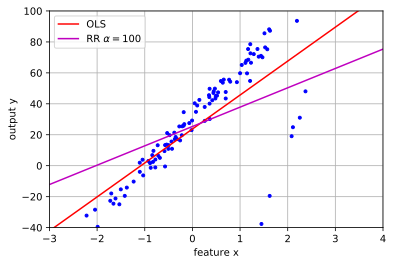

In [3]:
outfig

# RANSAC
- **RAN**dom **SA**mple **C**onsensus
  - attempt to robustly fit a regression model in the presence of corrupted data (outliers).
  - works with any regression model.
- **Idea:**
  - split the data into inliers (good data) and outliers (bad data).
  - learn the model only from the inliers

# Random sampling
- Repeat many times with random subset of points (usually just enough to fit the model)
    - fit a model to the subset.
    - classify all data as inlier or outlier by calculating the residuals (prediction errors) and comparing to a threshold.  The set of inliers is called the _consensus set_.
  - save the model with the highest number of inliers.
- Use the largest consensus set to learn the final model.


In [4]:

random.seed(1002)
ransacfig = plt.figure(figsize=(12,3))
for i in range(3):    
    inds = [random.choice(range(len(outlinY))) for j in range(2)]
    
    ols = linear_model.LinearRegression()
    ols.fit(outlinX[inds], outlinY[inds])

    ypred = ols.predict(xr)
    T = 15
    
    # calculate number of inliers
    ytpred = ols.predict(outlinX)
    numin = sum(abs(ytpred-outlinY)<=T)
    
    plt.subplot(1,3,i+1)
    plt.plot(outlinX, outlinY, 'b.', markeredgecolor='k')
    plt.plot(outlinX[inds], outlinY[inds], 'ro', label='selected points', markeredgecolor='k')
    plt.plot(xr, ypred, 'r-', label='estimated line')
    plt.plot(xr, ypred+T, 'r--', linewidth=1, label='inlier threshold')
    plt.plot(xr, ypred-T, 'r--', linewidth=1)
    plt.grid(True); plt.axis(oaxbox)
    plt.title("number of inliers = " + str(numin))
    if i==0:
        plt.legend(fontsize=8, loc='upper left')


plt.close()

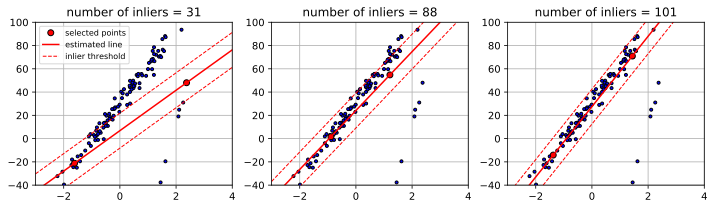

In [5]:
ransacfig

<br><br><br><br>

# RANSAC
- More iterations increases the probability of finding the correct function.
  - higher probability to select a subset of points contains all inliers.
- Threshold typically set as the median absolute deviation of $y$.

In [6]:
def plot_regr_trans_1d(model, axbox, X, Y, feattrans=None):
    xr = linspace(axbox[0], axbox[1], 100)

    # predict the function
    if feattrans != None:
        xrf   = feattrans(xr[:,newaxis])
    else:
        xrf = xr[:,newaxis]
    
    if model.__class__.__name__ == "GaussianProcessRegressor":
        Ypred, Ystd = model.predict(xrf, return_std=True)
        hasstd = True
    else:
        Ypred = model.predict(xrf)
        hasstd = False

    if hasstd:
        plt.fill_between(xr, Ypred - 2*Ystd, Ypred + 2*Ystd,
                     alpha=0.2, color='k')

    plt.plot(X, Y, 'b.')
    plt.plot(xr, Ypred, 'r-')
    plt.axis(axbox); plt.grid(True)

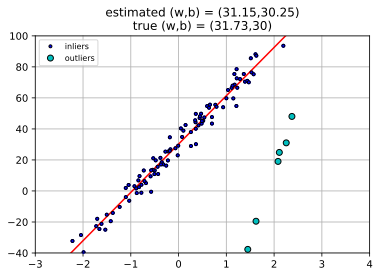

In [7]:
# use RANSAC model (defaults to linear regression)
rlin = linear_model.RANSACRegressor(random_state=1234)
rlin.fit(outlinX, outlinY)

inlier_mask = rlin.inlier_mask_
outlier_mask = logical_not(inlier_mask)

plt.figure()
plot_regr_trans_1d(rlin, oaxbox, outlinX, outlinY)
plt.plot(outlinX[inlier_mask], outlinY[inlier_mask], 'b.', label='inliers', markeredgecolor='k')
plt.plot(outlinX[outlier_mask], outlinY[outlier_mask], 'co', label='outliers', markeredgecolor='k')
leg = plt.legend(fontsize=8, loc='upper left')
plt.title('estimated (w,b) = (%0.4g,%0.4g)\ntrue (w,b) = (%0.4g,%0.4g)' % 
          (rlin.estimator_.coef_, rlin.estimator_.intercept_, lincoefs, linbias));

# Non-linear regression
- So far we have only considered linear regression: $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$
- Similar to classifcation, we can do non-linear regression by forming a feature vector of $\mathbf{x}$ and then performing linear regression on the feature vector.

# Polynomial regression
- p-th order Polynomial function
  - $f(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \cdots + w_p x^p$
- Collect the terms into a vector
  - $f(x) = \begin{bmatrix}w_0 &w_1 &w_2 &\cdots &w_p\end{bmatrix}*\begin{bmatrix}1\\x\\x^2 \\\vdots\\x^p\end{bmatrix} = \mathbf{w}^T \phi(x)$ 
  - weight vector $\mathbf{w} = \begin{bmatrix}w_0 \\w_1 \\w_2 \\\vdots \\w_p\end{bmatrix}$; polynomial feature vector: $\phi(x) = \begin{bmatrix}1\\x\\x^2 \\\vdots\\x^p\end{bmatrix}$
- Now it's a linear function, so we can use the same linear regression!

# Example

- 1st to 6th order polynomials

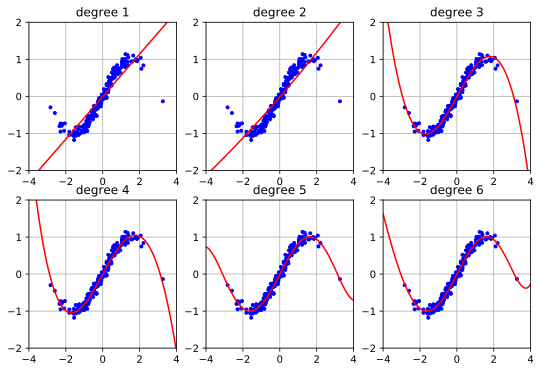

In [8]:
# example data
polyX = random.normal(size=200)
polyY = sin(polyX) + 0.1*random.normal(size=200)
polyX = polyX[:,newaxis]

plt.figure(figsize=(9,6))
naxbox = [-4, 4, -2, 2]

for d in [1,2,3,4,5,6]:
    # extract polynomial features with degree d
    polyfeats = preprocessing.PolynomialFeatures(degree=d)
    polyXf = polyfeats.fit_transform(polyX)

    # fit the parameters
    plin = linear_model.LinearRegression()
    plin.fit(polyXf, polyY)

    # make plot
    plt.subplot(2,3,d)
    plot_regr_trans_1d(plin, naxbox, polyX, polyY, polyfeats.transform)
    plt.title("degree " + str(d))

# Example: Boston data
- Using "percentage of lower-status" feature
- Increasing polynomial degree $d$ will decrease MSE of training data
  - more complicated model always fits data better
  - (but it could overfit)

In [9]:
subsamp = 3
boston = datasets.load_boston()
bostonY = boston['target'][::subsamp]
bostonX = boston['data'][::subsamp,12][:,newaxis]
bostonaxbox = [0,40,0,50]

In [10]:
polyfeats = {}
plin = {}
MSE = {}
for d in [1,2,3,4,5,6]:
    # extract polynomial features with degree d
    polyfeats[d] = preprocessing.PolynomialFeatures(degree=d)
    bostonXf = polyfeats[d].fit_transform(bostonX)

    # fit the parameters
    plin[d] = linear_model.LinearRegression()
    plin[d].fit(bostonXf, bostonY)

    # calculate mean-square error on training set
    MSE[d] = metrics.mean_squared_error(bostonY, plin[d].predict(bostonXf))

In [11]:
pfig = plt.figure(figsize=(10,6))
for d in [1,2,3,4,5,6]:
    # make plot
    plt.subplot(2,3,d)
    plot_regr_trans_1d(plin[d], bostonaxbox, bostonX, bostonY, polyfeats[d].transform)
    plt.ylabel('Home Price ($1000s)')
    plt.title('degree={}; MSE={:.5f}'.format(d, MSE[d]), fontsize=10)
plt.close()

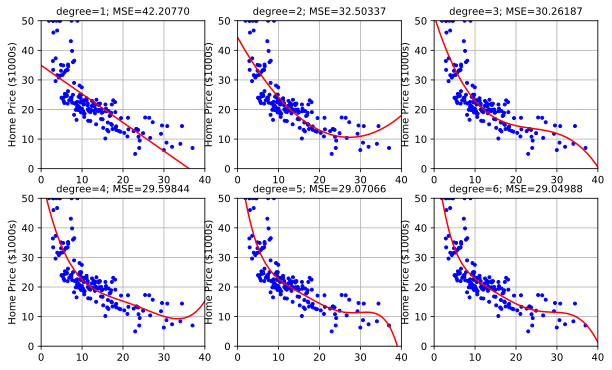

In [12]:
pfig

...

# Select degree using Cross-Validation
- Minimizing the MSE on the training set will overfit
  - More complex function always has lower MSE on training set
- Use cross-validation to select the proper model
  - the parameters we want to change are in feature transformation step
  - Use `pipeline` to merge all steps into one object for easier cross-validation

- `pipeline` object
  - pass an array of stages
  - each entry is a tuple with the stage name and transformer (implements `.fit`, `.transform`)
  - the last entry should be a model (implements `.fit`)

In [13]:
# make the pipeline
polylin = pipeline.Pipeline([
        ('polyfeats', preprocessing.PolynomialFeatures(degree=1)), 
        ('linreg',    linear_model.LinearRegression())
    ])

In [14]:
# set the parameters for grid search
# the parameters in each stage are named: <stage>__<parameter> 
paramgrid = {
    "polyfeats__degree": array([1, 2, 3, 4, 5, 6]),
}

# do the cross-validdation search - use -MSE as the score for maximizing
plincv = model_selection.GridSearchCV(polylin, paramgrid, cv=5, n_jobs=-1,
                                      scoring='neg_mean_squared_error')
plincv.fit(bostonX, bostonY)

print(plincv.best_params_)

{'polyfeats__degree': 5}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
def extract_grid_scores(modelcv, paramgrid):
    "extract CV scores from GridSearchCV and put into a matrix"
    # get parameters
    pkeys = list(paramgrid.keys())
    
    # initialize empty score matrix
    scoresize = [len(paramgrid[p]) for p in pkeys]
    avgscores = zeros(scoresize)

    # fill in the matrix with run for each parameter set
    for rm,rp in zip(modelcv.cv_results_['mean_test_score'], modelcv.cv_results_['params']):
        # get the index into each of the parameter lists
        myind = [where(rp[p] == paramgrid[p]) for p in pkeys]
        avgscores[tuple(myind)] = rm    # put the score

    # location of best score
    bestind = [where(modelcv.best_params_[p] == paramgrid[p]) for p in pkeys]

    return avgscores, pkeys, bestind

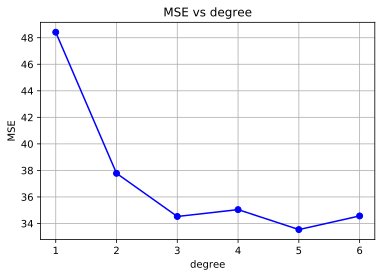

In [16]:
avgscores,pnames,bestind = extract_grid_scores(plincv, paramgrid)
plt.figure()
plt.plot(paramgrid['polyfeats__degree'], -avgscores, 'bo-')
plt.xlabel('degree'); plt.ylabel('MSE'); plt.grid(True);
plt.title('MSE vs degree');

# Polynomial features: 2D Example
- 2D feature vectors: 
  - $\mathbf{x} = \begin{bmatrix}x_1 &x_2\end{bmatrix}^T$
- degree 2 polynomial transformation:
  - $\phi(\mathbf{x}) = \begin{bmatrix}x_1^2& x_1 x_2 & x_2^2\end{bmatrix}^T$
- degree 3 polynomial transformation: 
  - $\phi(\mathbf{x}) = \begin{bmatrix}x_1^3& x_1^2 x_2 & x_1 x_2^2 & x_3^3\end{bmatrix}^T$

In [17]:
def plot_regr_trans_2d(model, axbox, X, Y, feattrans=None):
    # maek grid    
    xr = [linspace(axbox[0],axbox[1],100), 
          linspace(axbox[2],axbox[3],100)]
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
    if feattrans != None:
        allptsf = feattrans(allpts)
    else:
        allptsf = allpts
    
    
    if model.__class__.__name__ == "GaussianProcessRegressor":
        tmpY, tmpstd = model.predict(allptsf, return_std=True)
        ypred = tmpY.reshape(xgrid0.shape)
        ystd  = tmpstd.reshape(xgrid0.shape)
        hasstd = True
        
        tmpYX, tmpstdX = model.predict(X, return_std=True)
    else:
        ypred = model.predict(allptsf).reshape(xgrid0.shape)
        hasstd = False
    
    
    Yr = Y.max()-Y.min()
    vmin = Y.min()-0.1*Yr
    vmax = Y.max()+0.1*Yr
    
    if not hasstd:
        plt.imshow(ypred, origin='lower', extent=axbox, aspect='auto', 
                   vmin=vmin, vmax=vmax, cmap='jet')
        plt.scatter(X[:,0], X[:,1], c=Y, vmin=vmin, vmax=vmax, cmap='jet', edgecolors='k')

        plt.grid(True); plt.axis(axbox)
    else:
        plt.subplot(1,2,1)
        plt.imshow(ypred, origin='lower', extent=axbox, aspect='auto', 
                   vmin=vmin, vmax=vmax, cmap='jet')
        plt.scatter(X[:,0], X[:,1], c=Y, vmin=vmin, vmax=vmax, cmap='jet', edgecolors='k')
        plt.grid(True); plt.axis(axbox)
        
        Yr = ystd.max()-ystd.min()
        vmin = ystd.min()-0.1*Yr
        vmax = ystd.max()+0.1*Yr        
        
        plt.subplot(1,2,2)
        plt.imshow(ystd, origin='lower', extent=axbox, aspect='auto', 
                 vmin=vmin, vmax=vmax, cmap='jet')
        plt.scatter(X[:,0], X[:,1], c=tmpstdX, vmin=vmin, vmax=vmax, cmap='jet', edgecolors='k')
        plt.grid(True); plt.axis(axbox)

In [18]:
# setup dataset
bostonaxbox2 = [3,9,0,40]
bostonY = boston['target'][::subsamp]
bostonX = boston['data'][::subsamp,[5,12]]

In [19]:
plin = {}
polyfeats = {}
for i,d in enumerate([2,3]):
    # get polynomial features
    polyfeats[d] = preprocessing.PolynomialFeatures(degree=d)
    bostonXf = polyfeats[d].fit_transform(bostonX)

    # learn with both dimensions
    plin[d] = linear_model.LinearRegression()
    plin[d].fit(bostonXf, bostonY)

    # calculate MSE
    MSE = metrics.mean_squared_error(bostonY, plin[d].predict(bostonXf))

In [20]:
pfig = plt.figure(figsize=(11,4))
for i,d in enumerate([2,3]):
    # make figure
    plt.subplot(1,2,i+1)
    plot_regr_trans_2d(plin[d], bostonaxbox2, bostonX, bostonY, polyfeats[d].transform)
    cbar = plt.colorbar()
    cbar.set_label('Home Price ($1000s)')
    plt.xlabel('number of rooms'); plt.ylabel('percent of low-status households')
    plt.title('degree=%d' % (d,))
plt.close()

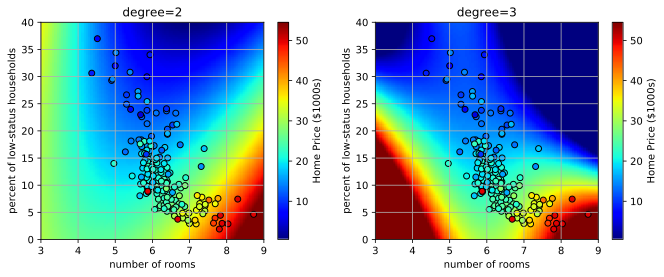

In [21]:
pfig

# Kernel Ridge Regression
- Apply _kernel trick_ to ridge regression
  - turn linear regression into non-linear regression
  - use kernel $k(x,x')$
- Closed form solution:
  - for an input point $\mathbf{x}_*$,
    - prediction: $y_* = \mathbf{k}_*^T (\mathbf{K} + \alpha I) ^{-1} \mathbf{y}$
      - $\mathbf{K} = \begin{bmatrix}k(\mathbf{x}_1,\mathbf{x}_1)&\cdots&k(\mathbf{x}_1,\mathbf{x}_N)\\\vdots & \ddots & \vdots\\k(\mathbf{x}_N,\mathbf{x}_1)&\cdots&k(\mathbf{x}_N,\mathbf{x}_N)\end{bmatrix}$ is the kernel matrix ($N \times N$)
      - $\mathbf{k}_* = [k(\mathbf{x}_1,\mathbf{x}_*),\cdots,k(\mathbf{x}_N,\mathbf{x}_*)]^T$ is vector containing the kernel values between $\mathbf{x}_*$ and all training points $\mathbf{x}_i$.

# Example: Polynomial Kernel
- Note: it's the same as using polynomial features and linear regression!
  - Using the kernel, we don't need to explicitly calculate the polynomial features.
  - But, we do need to calculate the kernel function between all pairs of training points.

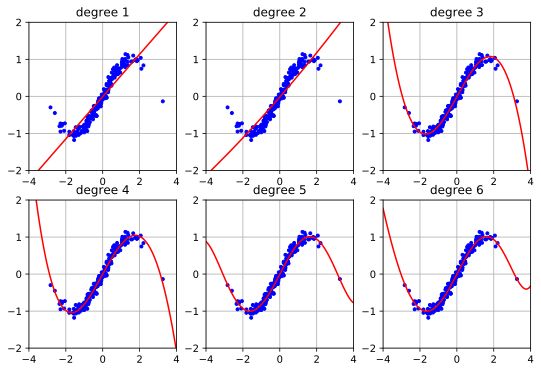

In [22]:
plt.figure(figsize=(9,6))

for d in [1,2,3,4,5,6]:

    # fit the parameters
    krr = kernel_ridge.KernelRidge(alpha=1, kernel='poly', degree=d)
    krr.fit(polyX, polyY)
    
    # plot the function
    plt.subplot(2,3,d)
    plot_regr_trans_1d(krr, naxbox, polyX, polyY)
    plt.title("degree " + str(d))

# Example: RBF kernel
- gamma controls the smoothness
  - small gamma will etimate a smooth function
  - large gamma will estimate a wiggly function

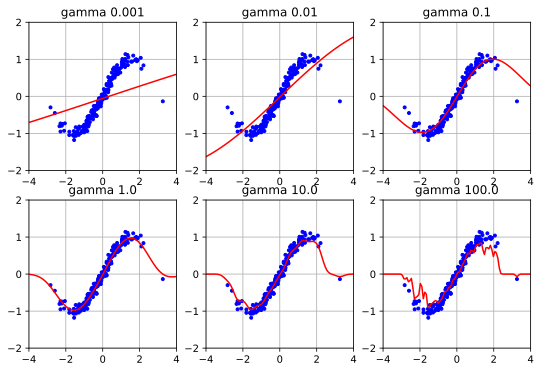

In [23]:
plt.figure(figsize=(9,6))

for i,g in enumerate(logspace(-3,2,6)):
    # fit the parameters
    krr = kernel_ridge.KernelRidge(alpha=1, kernel='rbf', gamma=g)
    krr.fit(polyX, polyY)
    
    # plot the function
    plt.subplot(2,3,i+1)
    plot_regr_trans_1d(krr, naxbox, polyX, polyY)
    plt.title("gamma " + str(g))

# Boston Data: Cross-validation
- RBF kernel
  - cross-validation to select $\alpha$ and $\gamma$.

In [24]:
# parameters for cross-validation
paramgrid = {'alpha': logspace(-3,3,10),
          'gamma': logspace(-3,3,10)}

# do cross-validation
krrcv = model_selection.GridSearchCV(
  kernel_ridge.KernelRidge(kernel='rbf'),  # estimator
  paramgrid,                              # parameters to try
  scoring='neg_mean_squared_error',       # score function
  cv=5,                                   # number of folds
  n_jobs=-1, verbose=True)
krrcv.fit(bostonX, bostonY)

print(krrcv.best_score_)
print(krrcv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-20.40686154806781
{'alpha': 0.004641588833612777, 'gamma': 0.004641588833612777}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
(avgscores, pnames, bestind) = extract_grid_scores(krrcv, paramgrid)

kfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(-avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w')
plt.ylabel(pnames[0] + ' index'); plt.xlabel(pnames[1] + ' index')
plt.grid(True)
plt.title('MSE for different parameters')
plt.colorbar(); plt.axis('image');

plt.subplot(1,2,2)
plot_regr_trans_2d(krrcv, bostonaxbox2, bostonX, bostonY)
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms')
plt.ylabel('percent of low-status households')
plt.title('KRR plot');
plt.close()

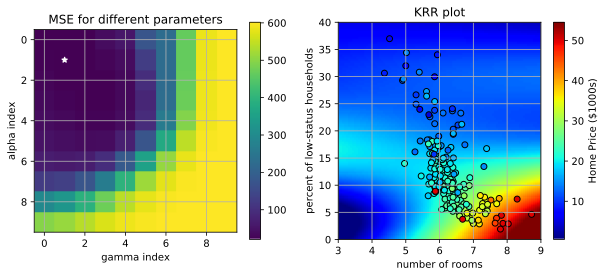

In [26]:
kfig

# Gaussian Process Regression
- *Gaussian Process* is an infinite collection of r.v.s where any finite subset of r.v.s is joint Gaussian distributed.
  - infinite collection of values -> function
  - GP is prior distribution over **functions**.
- Denoted as: $f(\mathbf{x}) \sim {\cal GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$
    - function value: $f(\mathbf{x})$ is a distribution of $f$ at location $\mathbf{x}$.
    - mean function: $m(\mathbf{x})$ is the mean function. Usually $m(\mathbf{x})=c$, a constant.
    - covariance function: $\mathrm{cov}(f(\mathbf{x}), f(\mathbf{x}')) = k(\mathbf{x},\mathbf{x}')$
      - covariance of function values depends on inputs through the kernel $k$.    
  

- For any $(x_1,\cdots,x_N)$, the distribution of function values is:
  - $f_1,\cdots,f_N | \mathbf{x}_N,\cdots,\mathbf{x}_N \sim \cal{N}(0,\mathbf{K})$  
    - $\mathbf{K}$ is the kernel matrix for points $\{\mathbf{x}_N,\cdots,\mathbf{x}_N\}$

# Examples of GP priors
- the kernel defines the types of functions that are regressed

In [60]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

kernels = [DotProduct(), DotProduct()**2, DotProduct()**3, RBF()]
kernelnames = ['linear', 'poly2', 'poly3', 'RBF']

pfig = plt.figure(figsize=(9, 5))
for i,k in enumerate(kernels):
    # Specify Gaussian Process
    gp = gaussian_process.GaussianProcessRegressor(kernel=k)

    # Plot prior
    plt.subplot(2, 2, i+1)
    X_ = linspace(-3, 3, 100)
    y_mean, y_std = gp.predict(X_[:, newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(-3, 3)
    plt.ylim(-4, 4)
    plt.title(kernelnames[i])
    plt.grid(True)
plt.close()


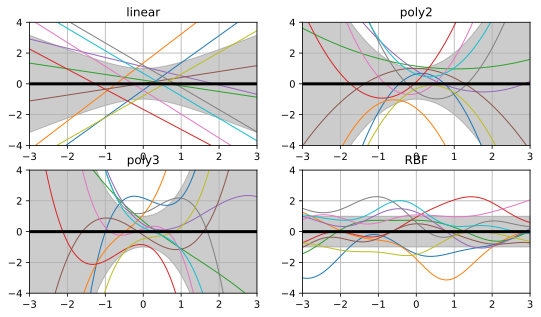

In [61]:
pfig

...

# Gaussian Process Regression
- Model framework
  - observation noise: $p(\mathbf{y}|\mathbf{f}) = {\cal N}(\mathbf{y}|\mathbf{f},  \sigma^2 \mathbf{I})$
    - equivalent to mean-squared error loss
  - function prior: $\mathbf{f} \sim {\cal GP}(0,k(\mathbf{x}, \mathbf{x}'))$
- Training: given dataset $\{\mathbf{X}, \mathbf{y}\}$
  - compute the posterior distribution of the function values for the observed data:
     - $p(\mathbf{f}|\mathbf{X},\mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{f})p(\mathbf{f})}{p(\mathbf{y}|\mathbf{X})}$
- Inference: given a new point $\mathbf{x}_*$
  - $p(f_*|x_*,\mathbf{X},\mathbf{y}) = \int p(f_*|x_*,\mathbf{f}) p(\mathbf{f}|\mathbf{X}, \mathbf{y})d\mathbf{f}$
    - averages the predictions over all probable function values $\mathbf{f}$.

# GP Prediction
- All distributions are Gaussian, so there is a closed-form solution.
- The predictive distribution is Gaussian:
  - $p(f_*|x_*,\mathbf{X},\mathbf{y}) = {\cal N}(f_*| \mu_*,\sigma_*^2)$
    - mean of prediction: $\mu_* = \mathbf{k}_*^T (\mathbf{K} + \sigma^2 I) ^{-1} \mathbf{y}$
    - variance of predictions: $\sigma_*^2 = k_{**} - \mathbf{k}_*^T (\mathbf{K} + \sigma^2 I) ^{-1}\mathbf{k}_*$
      - where $k_{**} = k(\mathbf{x}_*,\mathbf{x}_*)$.
  - The uncertainty of the prediction is measured with its variance.
    - (higher values means more uncertain).

- GPR with a linear kernel is equivalent to Bayesian linear regression
  - `DotProduct()` - linear kernel
  - `WhiteKernel()` - observation noise ($\sigma^2$)
  - gray area shows 2 standard deviations around the mean (95% confidence region)

In [29]:
lsaxbox = [-3,3,-2,4]
laxbox = [-3, 3, -50, 100]

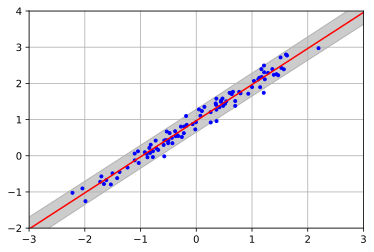

In [30]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
k = DotProduct() + WhiteKernel()
gpr = gaussian_process.GaussianProcessRegressor(kernel=k, random_state=5489, normalize_y=True)
linYs = linY/std(linY)  # normalize Y to unit variance (GPR will be better behaved)
gpr.fit(linX, linYs)
plot_regr_trans_1d(gpr, lsaxbox, linX, linYs)

...

In [31]:
naxbox2 = [-5, 5, -2, 2]

# Non-linear regression using kernels
- kernels functions allow non-linear regression
  - `DotProduct()` - linear
  - `DotProduct()**2` - 2nd order polynomial
  - `DotProduct()**3` - 3rd order polynomial
  - `RBF()` - Radial-basis function
- Applying the kernel trick to Bayesian linear regression will yield GPR

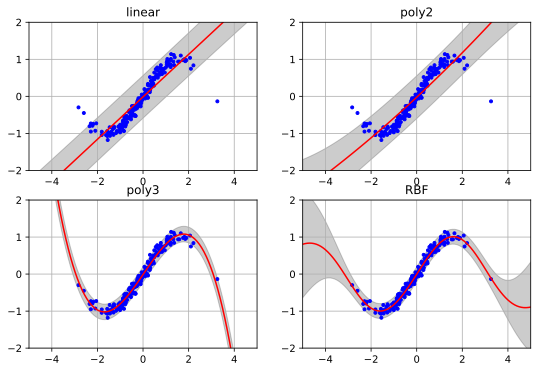

In [32]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
kernels = [  DotProduct()    + WhiteKernel(), 
             DotProduct()**2 + WhiteKernel(), 
             DotProduct()**3 + WhiteKernel(), 
             RBF()           + WhiteKernel()   ]
kernelnames = ['linear', 'poly2', 'poly3', 'RBF']
plt.figure(figsize=(9,6))
for i,k in enumerate(kernels):
    gpr = gaussian_process.GaussianProcessRegressor(kernel=k, random_state=0, normalize_y=True)
    gpr.fit(polyX, polyY)
    plt.subplot(2,2,i+1)
    plot_regr_trans_1d(gpr, naxbox2, polyX, polyY)
    plt.title(kernelnames[i])

...

- kernels can be summed, multiplied, and exponentiated to make new kernels
  - e.g., `RBF() + DotProduct()**2 + WhiteKernel()`
  - regressed function is a sum of quadratic and RBF functions

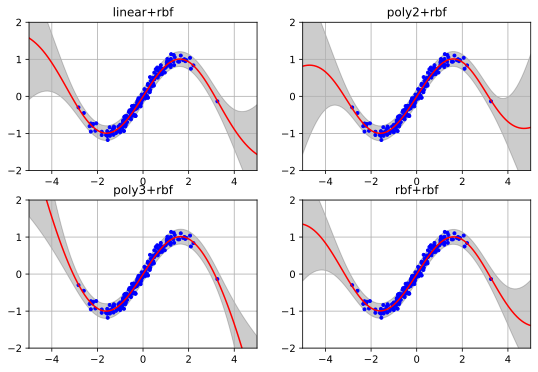

In [59]:
kernels = [  DotProduct()    + RBF() + WhiteKernel(), 
             DotProduct()**2 + RBF() + WhiteKernel(), 
             DotProduct()**3 + RBF() + WhiteKernel(), 
             RBF(length_scale=0.01) + RBF() + WhiteKernel(),
          ]
kernelnames = ['linear+rbf', 'poly2+rbf', 'poly3+rbf', 'rbf+rbf']
plt.figure(figsize=(9,6))
for i,k in enumerate(kernels):
    gpr = gaussian_process.GaussianProcessRegressor(kernel=k, random_state=0, normalize_y=True)
    gpr.fit(polyX, polyY)
    plt.subplot(2,2,i+1)
    plot_regr_trans_1d(gpr, naxbox2, polyX, polyY)
    plt.title(kernelnames[i])

...

- As a Bayesian method, GPR handles lack of data well
  - the uncertainty (stddev of the prediction) increases when less data is available.

In [34]:
kernels = [ DotProduct()**2 + WhiteKernel(), 
            DotProduct()**3 + WhiteKernel(), 
            RBF()           + WhiteKernel() ]
kernelnames = ['poly2', 'poly3', 'rbf']

sfig = plt.figure(figsize=(10,6))
for j,k in enumerate(kernels):
    for i,s in enumerate([20,10,5,2]):
        gpr = gaussian_process.GaussianProcessRegressor(kernel=k, random_state=0, normalize_y=True)
        gpr.fit(polyX[::s], polyY[::s])
        plt.subplot(3,4,i+1+j*4)
        plot_regr_trans_1d(gpr, naxbox2, polyX[::s], polyY[::s])
        if (i==0):
            plt.ylabel(kernelnames[j])
        if (j==0):
            plt.title("{} points".format(len(polyY[::s])))
plt.close()

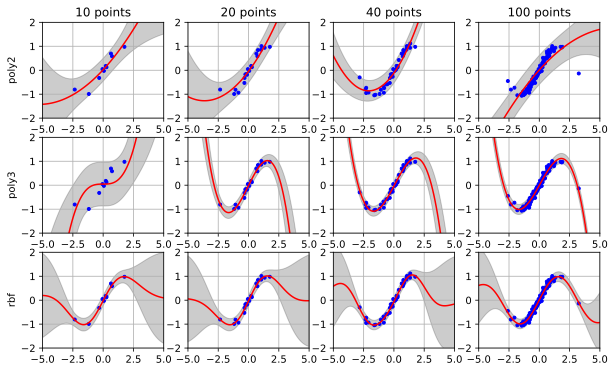

In [35]:
sfig

# Estimation of Kernel Hyperparameters
- the hyperparameters of the kernel are estimated by maximizing the marginal likelihood:
    - marginal likelihood (aka model evidience)
      - $p(\mathbf{y}|\mathbf{X}) = \int p(\mathbf{y}|\mathbf{X},\mathbf{f})p(\mathbf{f})d\mathbf{f}$ 
      - averages over all probable functions
    - Use iterative methods to maximize
      - $\alpha^* = \mathop{\mathrm{argmax}}_{\alpha} \log p(\mathbf{y}|\mathbf{X})$
- Advantages:
  - typically more efficient than grid-search when there are many kernel hyperparameters.
  - principled approach to model selection
- Disadvantage:
  - difficult optimization problem, possibly many local maximum

# Intuition of MML
- Consider the space of datasets $D$.
  - A *constrained (simple)* model can only represent a few datasets.
    - the likelihood of data $p(D|M)$ for those datasets should be large, since it integrates to 1
  - A *flexible* (complex)* model can represent many datasets.
    - the likelihood of data $p(D|M)$ for those datasets should be small.
  - For a given $D$, by choosing the model with highest $p(D|M)$, we select the least complex model that fits the data.
<center><img src="imgs/occam.gif" width=400></center>

# Example on Boston
- try 2nd-order polynomial and RBF kernels.
- remember to rescale the outputs Y to unit variance

In [36]:
kernels = [DotProduct()**2 + WhiteKernel(), 
           RBF()           + WhiteKernel()]
kernelnames = ['poly2', 'RBF']

bostonYs  = bostonY/std(bostonY) # rescale outputs

gpr = [None]*2
for i,k in enumerate(kernels):
    gpr[i] = gaussian_process.GaussianProcessRegressor(
        kernel=k, random_state=5489, 
        n_restarts_optimizer=5, normalize_y=True)
    gpr[i].fit(bostonX, bostonYs)

In [37]:
gprfig = [None]*2
for i,gg in enumerate(gpr):
    gprfig[i] = plt.figure(figsize=(10,4))
    plot_regr_trans_2d(gpr[i], bostonaxbox2, bostonX, bostonYs)
    plt.subplot(1,2,1)
    cbar = plt.colorbar()
    cbar.set_label('Home Price ($1000s)')
    plt.xlabel('number of rooms')
    plt.ylabel('percent of low-status households')
    plt.title('GPR {} (prediction)'.format(kernelnames[i]));
    plt.subplot(1,2,2)
    cbar = plt.colorbar()
    cbar.set_label('standard deviation')
    plt.xlabel('number of rooms')
    plt.ylabel('percent of low-status households')
    plt.title('GPR {} (stddev)'.format(kernelnames[i]));
    plt.close()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a 

- 2nd order polynomial kernel
  - stddev of prediction shows when the model is not confident

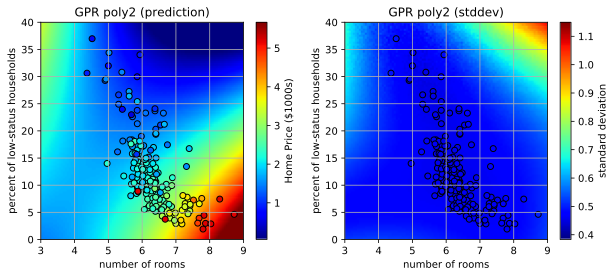

In [38]:
gprfig[0]

- RBF kernel
  - stddev of prediction shows when the model is not confident
  - Since the RBF kernel has finite extent, it is not confident where it doesn't see data.

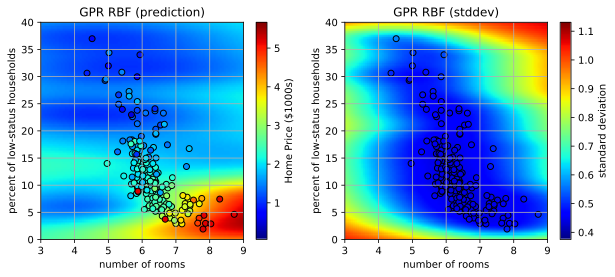

In [39]:
gprfig[1]

...

# Support Vector Regression (SVR)
- Borrow ideas from classification
  - Suppose we form a "band" of width $\epsilon$ around the function:
    - if a point is inside, then it is "correctly" predicted
    - if a point is outside, then it is incorrectly predicted

In [40]:
def plot_svr_1d(model, axbox, X, Y, label=False, showsv=False):
    xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
    Ypred = model.predict(xr)

    epsilon = model.epsilon
    
    plt.plot(X, Y, 'b.', label='points')
    plt.plot(xr, Ypred, 'r-', label='$f(x)$')    
    plt.plot(xr, Ypred+epsilon, 'r--', linewidth=1, label='$f(x)\\pm\\epsilon$')
    plt.plot(xr, Ypred-epsilon, 'r--', linewidth=1)
    
    if showsv:        
        ypred = model.predict(xr)
        ss = model.support_   # get support vector indicies
        plt.plot(X[ss], Y[ss], 'r.', label='support vectors')

    plt.axis(axbox); plt.grid(True)
    
    if label:
        plt.legend(loc=0)

In [41]:
epsilon = 11.5
svr = svm.SVR(C=1000, kernel='linear', epsilon=epsilon)
svr.fit(linX, linY)

axbox = [-3, 3, -50, 100]
svrfig = plt.figure()
plot_svr_1d(svr, laxbox, linX, linY)
plt.grid(True); plt.axis(laxbox)
plt.legend(loc='lower right')
plt.title('$\\epsilon=11.5$');
plt.close()

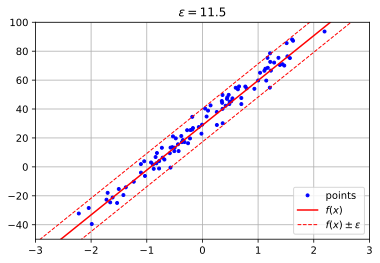

In [42]:
svrfig

- Allow some points to be outside the "tube".
  - penalty of point outside tube is controlled by $C$ parameter.
- SVR objective function:
$$\min_{\mathbf{w},b} \sum_{i=1}^N \left|y_i - (\mathbf{w}^T\mathbf{x}_i+b)\right|_{\epsilon} + \frac{1}{C}||\mathbf{w}||^2$$
  - find the least complex function with most points inside the tube.
- epsilon-insensitive error:
  - $\left|z\right|_{\epsilon} = \begin{cases} 0, & |z|\leq \epsilon \\ |z|-\epsilon, & |z|\gt \epsilon\end{cases}$
- Similar to SVM classifier, the points on the band will be the _support vectors_ that define the function.

# Different tube widths
- The points on/outside the tube are the _support vectors_.

In [43]:

svrfig = plt.figure(figsize=(10,6))
ind = 1
for C in [1,10]:
    for epsilon in [5,10,25]:
        svr = svm.SVR(C=C, kernel='linear', epsilon=epsilon)
        svr.fit(linX, linY)

        plt.subplot(2,3,ind)
        plot_svr_1d(svr, axbox, linX, linY, label=False, showsv=True)
        if (C==1):
            plt.title('$\\epsilon='+str(epsilon)+"$")
        if (epsilon==5):
            plt.ylabel('C='+str(C))
        if (ind==1):
            plt.legend(fontsize=7, loc='upper left')
        ind=ind+1
plt.close()

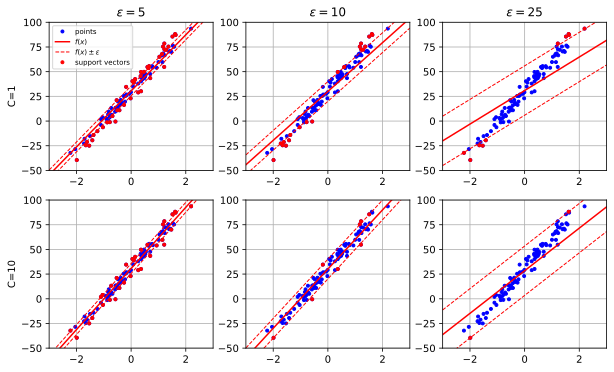

In [44]:
svrfig

...

# Kernel SVR
- Support vector regression can also be kernelized similar to SVM
  - turn linear regression to non-linear regression
- Polynomial Kernel:

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

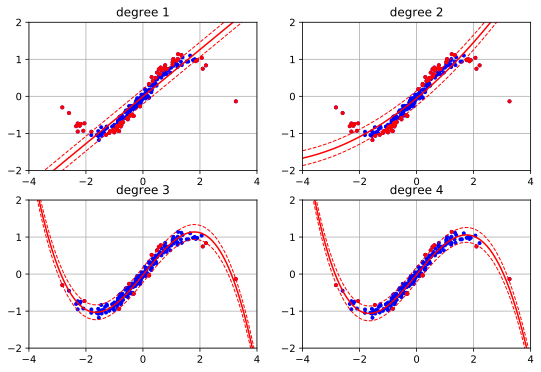

In [45]:
plt.figure(figsize=(9,6))

epsilon = 0.2

for d in [1,2,3,4]:
    # fit the parameters (poly SVR)
    svr = svm.SVR(C=1000, kernel='poly', coef0=0.1, degree=d, epsilon=epsilon)
    svr.fit(polyX, polyY)
        
    plt.subplot(2,2,d)
    plot_svr_1d(svr, naxbox, polyX, polyY, showsv=True)
    plt.title("degree " + str(d))

# SVR with RBF kernel

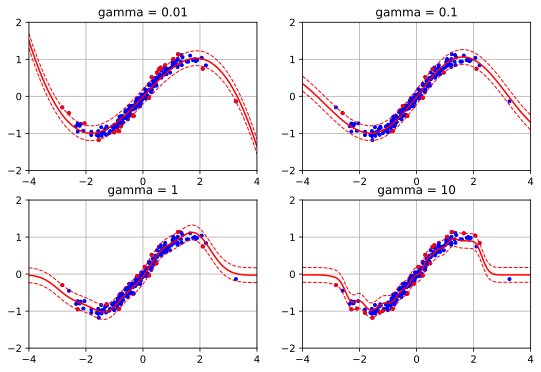

In [46]:
plt.figure(figsize=(9,6))

epsilon = 0.2

for i,g in enumerate([0.01, 0.1, 1, 10]):
    # fit the parameters: SVR with RBF
    svr = svm.SVR(C=1000, kernel='rbf', gamma=g, epsilon=epsilon)
    svr.fit(polyX, polyY)
        
    plt.subplot(2,2,i+1)
    plot_svr_1d(svr, naxbox, polyX, polyY, showsv=True)
    plt.title("gamma = " + str(g))

...

# Boston Data
- Cross-validation to select 3 parameters
  - C, $\gamma$, $\epsilon$

In [47]:
# parameters for cross-validation
paramgrid = {'C':       logspace(-3,3,10),
             'gamma':   logspace(-3,3,10),
             'epsilon': logspace(-2,2,10)}

# do cross-validation 
svrcv = model_selection.GridSearchCV(
    svm.SVR(kernel='rbf'),  # estimator
    paramgrid,                     # parameters to try
    scoring='neg_mean_squared_error',  # score function
    cv=5, 
    n_jobs=-1, verbose=1)                # show progress
svrcv.fit(bostonX, bostonY)

print(svrcv.best_score_)
print(svrcv.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    0.2s


-19.47732071915685
{'C': 1000.0, 'epsilon': 1.6681005372000592, 'gamma': 0.004641588833612777}


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    2.0s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [48]:
(avgscores, pnames, bestind) = extract_grid_scores(svrcv, paramgrid)

kfig = plt.figure(figsize=(10,4))
# show score map
plt.subplot(1,2,1)
plt.imshow(squeeze(-avgscores[bestind[0],:,:]), interpolation='nearest')
plt.plot(bestind[2], bestind[1], '*w')
plt.ylabel(pnames[1] + ' index'); plt.xlabel(pnames[2] + ' index')
plt.grid(True)
plt.title('MSE for different parameters\n$\epsilon$={:.3f}'.format(svrcv.best_params_['epsilon']))
plt.colorbar(); plt.axis('image');

# show regression function
vmin = bostonY.min()-10
vmax = bostonY.max()+10
plt.subplot(1,2,2)
plot_regr_trans_2d(svrcv, bostonaxbox2, bostonX, bostonY)
ss = svrcv.best_estimator_.support_
plt.scatter(bostonX[ss,0], bostonX[ss,1], c=bostonY[ss], vmin=vmin, vmax=vmax, lw=2, cmap='jet', edgecolors='k')
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms'); plt.ylabel('percent of low-status households');
plt.close()

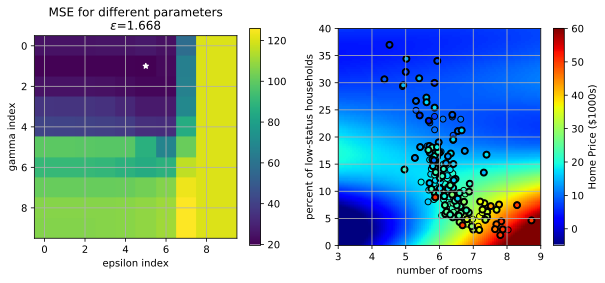

In [49]:
kfig

# Random Forest Regression
- Similar to Random Forest Classifier
  - Average predictions over many Decision Trees
    - Each decision tree sees a random sampling of the Training set
    - Each split in the decision tree uses a random subset of features
    - Leaf node of tree contains the predicted value.

In [50]:
def plot_rf_1d(model, axbox, X, Y, label=False, showdt=False):
    xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
    Ypred = model.predict(xr)

    if showdt:
        myalpha=0.25
    else:
        myalpha=1.0
    plt.plot(X, Y, 'b.', label='points', alpha=myalpha)
    
    if showdt:
        for i in model.estimators_:
            yy = i.predict(xr)
            plt.plot(xr, yy, 'm-')
    
    plt.plot(xr, Ypred, 'r-', label='forest', lw=2)
    plt.axis(axbox); plt.grid(True)
    
    if label:
        plt.legend(loc=0)

# Example
- Four decision trees
  - the regressed function has "steps" because of the decision tree has a constant prediction for ranges of feature values.

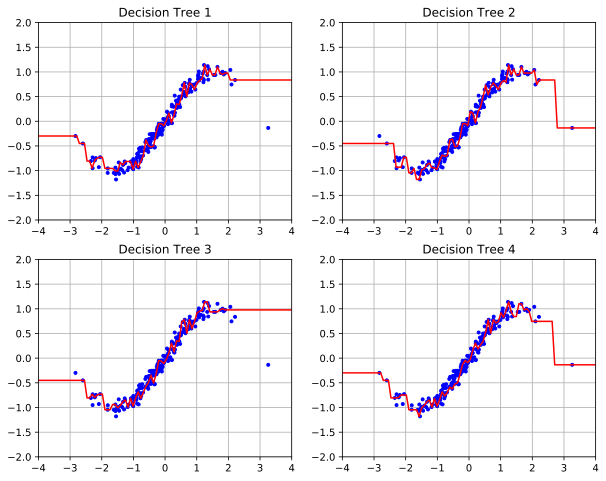

In [51]:
rf = ensemble.RandomForestRegressor(n_estimators=4, random_state=4487, n_jobs=-1)
rf.fit(polyX, polyY)

plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plot_regr_trans_1d(rf.estimators_[i], naxbox, polyX, polyY)
    plt.title('Decision Tree ' + str(i+1))

Text(0.5, 1.0, 'Random Forest Regressor w/ 4 trees')

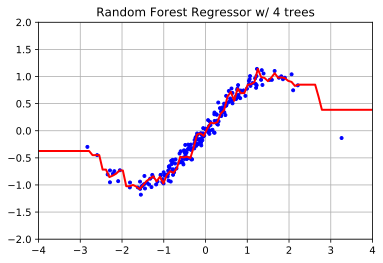

In [52]:
# the aggregated function
plt.figure()
plot_rf_1d(rf, naxbox, polyX, polyY)
plt.title('Random Forest Regressor w/ 4 trees')

- Using more trees...

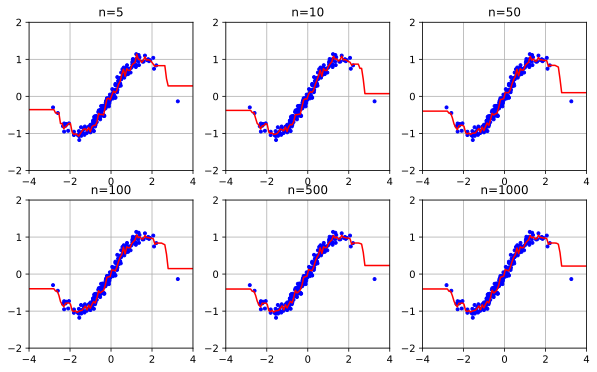

In [53]:
plt.figure(figsize=(10,6))
for i,n in enumerate([5, 10, 50, 100, 500, 1000]):
    plt.subplot(2,3,i+1)
    rf = ensemble.RandomForestRegressor(n_estimators=n, random_state=4487, n_jobs=-1)
    rf.fit(polyX, polyY)

    plot_regr_trans_1d(rf, naxbox, polyX, polyY)
    plt.title('n='+str(n))

<br><br><br><br>

# Boston data
- The regressed function looks "blocky"
  - looks more reasonable for areas without any data

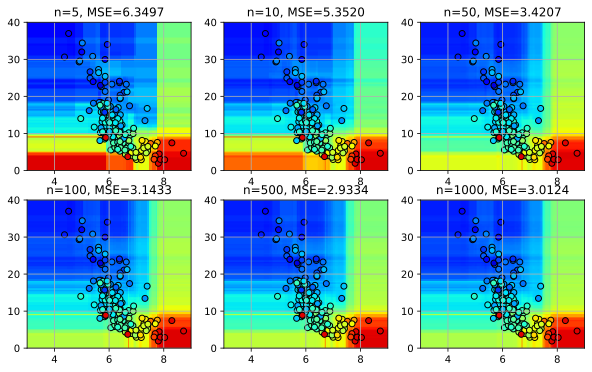

In [54]:
plt.figure(figsize=(10,6))
for i,n in enumerate([5, 10, 50, 100, 500, 1000]):
    plt.subplot(2,3,i+1)
    rf = ensemble.RandomForestRegressor(n_estimators=n, random_state=4487, n_jobs=-1)
    rf.fit(bostonX, bostonY)
    MSE = metrics.mean_squared_error(bostonY, rf.predict(bostonX))

    plot_regr_trans_2d(rf, bostonaxbox2, bostonX, bostonY)
    plt.title('n={}, MSE={:.4f}'.format(n, MSE))

- plot of MSE versus number of trees

In [55]:
ns = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 50, 100, 500, 1000]
mses = []
for n in ns:
    rf = ensemble.RandomForestRegressor(n_estimators=n, random_state=4487, n_jobs=-1)
    rf.fit(bostonX, bostonY)
    
    MSE = metrics.mean_squared_error(bostonY, rf.predict(bostonX))
    mses.append(MSE)

mfig = plt.figure(figsize=(8,4))
plt.semilogx(ns, mses, 'b.-')
plt.xlabel('num trees')
plt.ylabel('MSE')
plt.grid(True)
plt.close()

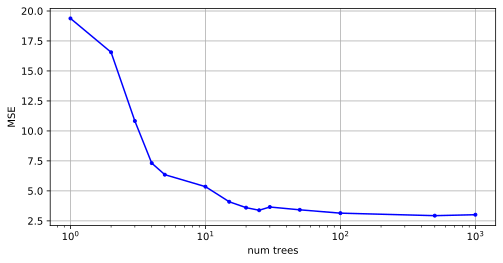

In [56]:
mfig

- Use cross-validation to select the tree depth

In [57]:
# parameters for cross-validation
paramgrid = {'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]),
            }

# do cross-validation
rfcv = model_selection.GridSearchCV(
    ensemble.RandomForestRegressor(n_estimators=100, random_state=4487),  # estimator
    paramgrid,                     # parameters to try
    scoring='neg_mean_squared_error',  # score function
    cv=5,
    n_jobs=-1, verbose=True
)
rfcv.fit(bostonX, bostonY)

print(rfcv.best_score_)
print(rfcv.best_params_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s


-21.42149477784048
{'max_depth': 4}


[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.0s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


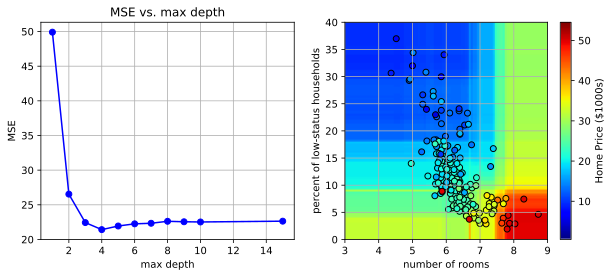

In [58]:
(avgscores, pnames, bestind) = extract_grid_scores(rfcv, paramgrid)

plt.figure(figsize=(10,4))
# show scores
plt.subplot(1,2,1)
plt.plot(paramgrid['max_depth'], -avgscores, 'bo-')
plt.xlabel('max depth'); plt.ylabel('MSE')
plt.title('MSE vs. max depth')
plt.grid(True)

# show regression function
plt.subplot(1,2,2)
plot_regr_trans_2d(rfcv, bostonaxbox2, bostonX, bostonY)
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms'); plt.ylabel('percent of low-status households');

<br><br><br><br>

# Regression Summary
- **Goal:** predict output $y\in\mathbb{R}$ from input $\mathbf{x}\in\mathbb{R}^d$.
  - i.e., learn the function $y = f(\mathbf{x})$.

<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Function</th>
<th>Training</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>Ordinary Least Squares</td>
<td>linear</td>
<td>minimize square error between observation and predicted output.</td>
<td>- closed-form solution.</td>
<td>- sensitive to outliers and overfitting.</td>
</tr>
<tr>
<td>ridge regression</td>
<td>linear</td>
<td>minimize squared error with $||w||^2$ (L2-norm) regularization term.</td>
<td>- closed-form solution;<br>- shrinkage to prevent overfitting.</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>LASSO</td>
<td>linear</td>
<td>minimize squared error with $\sum_{j=1}^d|w_j|$ (L1-norm) regularization term.</td>
<td>- feature selection (by forcing weights to 0)</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>OMP</td>
<td>linear</td>
<td>minimize squared error with constraint on number of non-zero weights (L0-norm).</td>
<td>- feature selection</td>
<td>- difficult optimization problem, sensitive to outliers.</td>
</tr>
<tr>
<td>RANSAC</td>
<td>same as the base model</td>
<td>randomly sample subset of training data and fit model; keep model with most inliers.</td>
<td>- ignores outliers.</td>
<td>- requires enough iterations to find good consensus set.</td>
</tr>
<tr>
<td>kernel ridge regression</td>
<td>non-linear (kernel function)</td>
<td>apply "kernel trick" to ridge regression.</td>
<td>- non-linear regression. <br>- Closed-form solution.</td>
<td>- requires calculating kernel matrix $O(N^2)$.<br>- cross-validation to select hyperparameters.</td>
</tr>
<tr>
<td>Gaussian process regression</td>
<td>non-linear (kernel function)</td>
<td>- compute posterior distribution<br>- estimate hyperparameters via MML.</td>
<td>- non-linear regression<br>- Closed-form solution.<br>-works well with small datasets<br>- hyperparameter estimation</td>
<td>- requires calculating kernel matrix $O(N^2)$.</td>
</tr>
<tr>
<td>kernel support vector regression</td>
<td>non-linear (kernel function)</td>
<td>minimize squared error, insensitive to epsilon-error.</td>
<td>- non-linear regression.<br>- faster predictions than kernel ridge regression.</td>
<td>- requires calculating kernel matrix $O(N^2)$.<br>- iterative solution (slow).<br>- cross-validation to select hyperparameters.</td>
</tr>
<tr>
<td>random forest regression</td>
<td>non-linear (ensemble)</td>
<td>aggregate predictions from decision trees.</td>
<td>- non-linear regression.<br>- fast predictions.</td>
<td>- predicts step-wise function.<br>- cannot learn a completely smooth function.</td>
</tr>
</table>

# Other Things
- _Feature normalization_
  - feature normalization is typically required for regression methods with regularization.
  - makes ordering of weights more interpretable (LASSO, RR).


- _Output transformations_
  - sometimes the output values $y$ have a large dynamic range (e.g., $10^{-1}$ to $10^5$).
    - large output values will have large error, which will dominate the training error.
    - in this case, it is better to transform the output values using the logarithm function.
      - $\hat{y} = \log_{10} (y)$, for example, see the tutorial.
  - Gaussian process regression assumes $y$ values are zero-mean and unit variance.
     - need to normalize to make it well behaved.